In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Preamble

Demo for the use of the statsmodels SARIMA model into a Waylay ML Adapter, using a weather data example.

* use `bin/jupyter_notebook env/ml_adapter_sarima ml_adapter/sarima_weather` to create a suitable conda environment and start the notebook.
* reuses timeseries retrieve as defined by the queries `sarimaWeatherHistoryHourly` and `sarimaWeatherHistoryDaily`

In [48]:
HOURLY_RESOURCE_ID = 'test_sarima_hourly'
DAILY_RESOURCE_ID = 'test_sarima_daily'
WAYLAY_PROFILE = 'aws-dev'

In [49]:
from waylay.sdk import WaylayClient
client = WaylayClient.from_profile(WAYLAY_PROFILE)

In [50]:
async def hourly_weather_data(query):
    data_resp = await client.queries.execute.execute_by_name(
        'sarimaWeatherHistoryHourly', query=query, select_path='data', response_type=list, timeout=10.0
    )
    [ dataset ] = data_resp
    df = pd.DataFrame(dataset['data'], columns=['timestamp', *(c['metric'] for c in dataset['columns'][1:])])
    df = df.set_index('timestamp')
    df.index=pd.to_datetime(df.index,unit='ms',utc=True)
    return df


In [78]:
weather_14 = await hourly_weather_data({ 'from':'-P14D' })
train_size = int(len(weather_14.index) * 0.8)
weather_14_train, weather_14_test = weather_14.iloc[:train_size], weather_14.iloc[train_size:]

In [269]:
import statsmodels.api as sm

endog_col='temperature'
exog_cols=[c for c in weather_14.columns if c not in ['temperature','temperature_feel']]
model = sm.tsa.SARIMAX(
    weather_14_train[endog_col],
    weather_14_train[exog_cols],
    seasonal_order=(1, 1, 1, 24),
    order=(1, 1, 1),
)
fitted_model = model.fit(maxiter=250, disp=10)
fitted_model.summary()


/opt/homebrew/Caskroom/miniconda/base/envs/ml_adapter_sarima/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/ml_adapter_sarima/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        temperature   No. Observations:                  268
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood                1048.500
Date:                            Tue, 29 Apr 2025   AIC                          -2079.000
Time:                                    13:10:32   BIC                          -2047.563
Sample:                                         0   HQIC                         -2066.338
                                            - 268                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp_feel      0.4718      0.042     11.252      0.000       0.390       0.554
pressure      -0.0295      0.056     -0.526      0.599      -0.139       0.080
wind_speed     0.1203      0.011     10.664      0.000       0.098       0.142
humidity      -0.0166      0.115     -0.144      0.886      -0.243       0.210
ar.L1          0.0021      0.258      0.008      0.993      -0.503       0.508
ma.L1         -0.2901      0.262     -1.108      0.268      -0.803       0.223
ar.S.L24      -0.2536      0.140     -1.808      0.071      -0.528       0.021
ma.S.L24      -0.3100      0.157     -1.972      0.049      -0.618      -0.002
sigma2      1.013e-05   1.05e-06      9.681      0.000    8.08e-06    1.22e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.86
Prob(Q):                              0.81   Prob(JB):                         0.65
Heteroskedasticity (H):               0.97   Skew:                             0.03
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

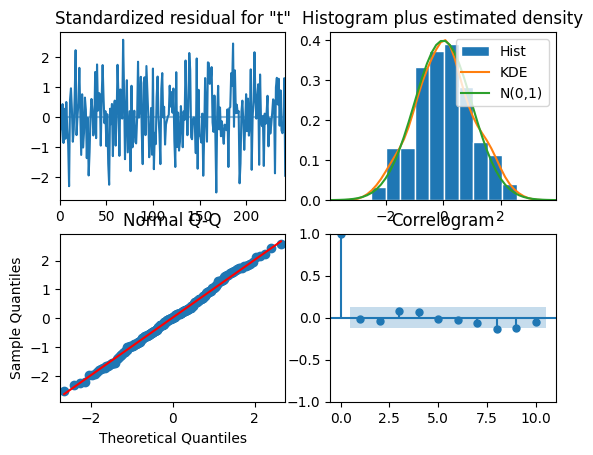

In [270]:
fitted_model.plot_diagnostics()
None

In [273]:
fitted_model.params

temp_feel     0.471785
pressure     -0.029462
wind_speed    0.120251
humidity     -0.016614
ar.L1         0.002121
ma.L1        -0.290122
ar.S.L24     -0.253588
ma.S.L24     -0.310034
sigma2        0.000010
dtype: float64

In [262]:
np.save('weather_14_train.npy',weather_14_train.values)

In [266]:
np.save('weather_14_train_idx.npy',weather_14_train.reset_index().values)

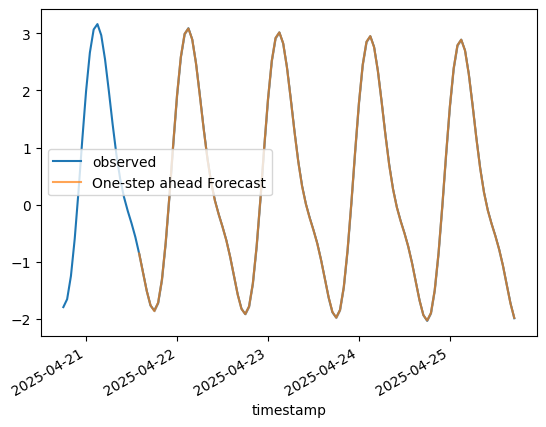

In [235]:
prediction = fitted_model.get_prediction(start=-100)
pred_ci = prediction.conf_int(alpha=0.05)
pred_mean = prediction.predicted_mean
ax = weather_14_train['temperature'].iloc[-24*5:].plot(label='observed')
pred_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1], color='k', alpha=.2
)
plt.legend()
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/ml_adapter_sarima/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/Caskroom/miniconda/base/envs/ml_adapter_sarima/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


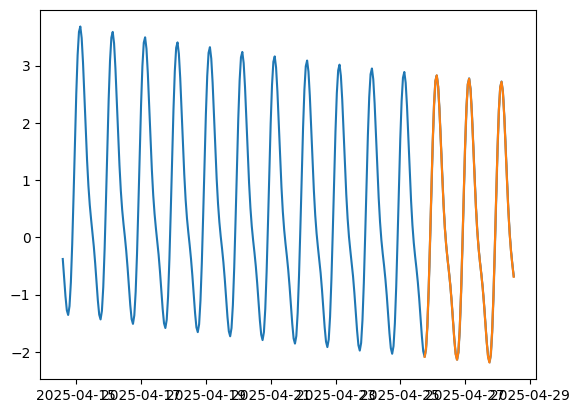

In [178]:
forecast_steps = weather_14_test.index.size
train_len = weather_14_train.index.size
forecast = fitted_model.get_prediction(
    start=train_len,end=train_len+ forecast_steps-1,
    exog=weather_14_test[exog_cols]
)
forecast_mean = forecast.predicted_mean

plt.plot(weather_14.temperature)
plt.plot(weather_14_test.index, forecast_mean)
# using a 50% confidence interval:
forecast_ci = forecast.conf_int(alpha=0.999)
plt.fill_between(
    weather_14_test.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1], 
    color='k', alpha=.2
)
plt.show()

In [179]:
fitted_model.params

temp_feel     0.471785
pressure     -0.029462
wind_speed    0.120251
humidity     -0.016614
ar.L1         0.002121
ma.L1        -0.290122
ar.S.L24     -0.253588
ma.S.L24     -0.310034
sigma2        0.000010
dtype: float64

In [180]:
current_weather = await hourly_weather_data({ 'resource': '7f33317b-a45e-4b0a-94a2-9bbbdc746cc1', 'until':'-P7D', 'from':'-P21D' })
train_size = int(len(current_weather.index) * 0.8)
current_weather_train, current_weather_test = current_weather.iloc[:train_size], current_weather.iloc[train_size:]

In [253]:
current_weather_model = sm.SARIMAX(
    current_weather_train['temperature'].values,
    current_weather_train[exog_cols].values,
    seasonal_order=(1, 1, 1, 24),
    order=(1, 1, 1),
)
current_fitted = current_weather_model.smooth(fitted_model.params)

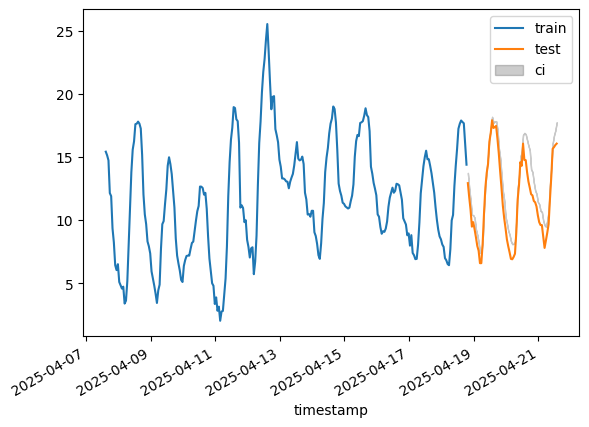

In [212]:
ax = current_weather_train['temperature'].plot(label='train')
current_weather_test['temperature'].plot(label='test')
end=current_fitted.data.endog.size
prediction = current_fitted.get_prediction(
    start=end, end=end+current_weather_test.index.size-1,
    exog=current_weather_test[exog_cols]
)
pred_ci = prediction.conf_int(alpha=0.5)
pred_mean = prediction.predicted_mean
# pred_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(
    current_weather_test.index,
    pred_ci[:, 0],
    pred_ci[:, 1], color='k', alpha=.2,
    label='ci'
)
plt.legend()
plt.show()

In [265]:
np.save('current_weather_test.npy',current_weather_test.values)

In [267]:
np.save('current_weather_test.idx.npy',current_weather_test.reset_index().values)

In [291]:
math.prod(np.array([[[1,2,3]]]).shape)

3

In [290]:
import math